> **Tip**
>
> This analysis has been tweaked to perform better on the (relatively) low
> memory Github workers used to build the site. It will require some minor
> modifications to generate the full animated movies from the paper which
> are noted where needed.


    <video autoplay loop muted playsinline>
        <source src="../../../assets/sv2_video.mp4" type="video/mp4">
    </video>

In [1]:
using Bootstrap
using ColorSchemes
using CSV
using DataFrames
using DataStructures
using Dates
using ImageContrastAdjustment
using ImageFiltering
using Measures
using Measurements
using OffsetArrays
using Plots
using Plots: px
using Statistics
using StatsPlots
using TableOperations
using TiffImages
using Unitful

Load some basic utility code

In [2]:
rootfolder = normpath(joinpath(@__DIR__, "..", "..", "..", ".."))
include(joinpath(rootfolder, "figures", "utils.jl"))

## Print details of the high resolution datasets

In [3]:
datasets = CSV.File(joinpath(rootfolder, "data", "fxm_highres_datasets.csv")) |> DataFrame

Row,date,volunteer,condition,dish,lane,scriptver,datapath,notes
,Date,String3,String7,String7,String31?,String15,String31,String31?
1,2023-03-10,V8,WT,dish2,Lane1WT_Pos0,3b244590,fxm_highres_ds1_230310_V8_WT,missing
2,2023-03-10,V8,BIX,dish2,Lane2BIX5uM_Pos0,3b244590,fxm_highres_ds2_230310_V8_BIX,missing
3,2023-10-04,V8,Duvel,dish1,missing,3b244590,fxm_highres_ds3_231004_V8_Duvel,Lack of complete attachment
4,2023-10-11,V1,LatB,dish1,Lane3LatB10uM_Pos0,3b244590,fxm_highres_ds4_231011_V1_LatB,Some minor flow


Load all data

In [4]:
function load_data(rootfolder)

    # load the standard dataset
    types = Dict(:abs_volume_um3 => Measurement{Float64})
    lowres = CSV.File(joinpath(rootfolder, "data", "fxm_uncaging_augmented.csv"), types = types) |> DataFrame

    # and then the high temporal resolution localities dataset
    highrescsvpath = joinpath(rootfolder, "data", "fxm_highres_augmented_w_localities.csv")
    highres = CSV.File(highrescsvpath, types = types, drop = [:footprint_cart, :locality_cart]) |> DataFrame;

    # The high resolution datasets were taken immediately after the standard
    # datasets so they start at the 45 minute time point. Additionally, they are
    # taken in serial instead of in parallel so we further need to offset the WT
    # condition by another 10 minutes since it was taken after the NHE1 condition on
    # 2023-03-10
    highres.time = uconvert.(u"minute", highres.time_s .* u"s") .+ 45.0u"minute";
    highres.time[highres.condition .== "WT"] .+= 10.0u"minute";
    lowres.time = uconvert.(u"minute", lowres.time_s .* u"s")
    linked = vcat(lowres, highres, cols = :union)

    linked = DataFrame(filter(x->any(x.time .> 50u"minute"), groupby(linked, [:date, :volunteer, :condition, :dish])))

    linked.reltime = linked.time .- 15u"minute";
    filter!(x->x.isencapsulated, linked);

    # remove early timepoints in the WT condition due to a punchy flow that moves
    # all cells at frame ~63
    filter!(x->(x.condition != "WT") || (x.reltime > -2.4u"minute"), linked)
    linked
end
linked = load_data(rootfolder);

### Compute baseline median volumes

In [5]:
med_vols = combine(groupby(linked, [:reltime, :condition]),
    :abs_volume_um3 => (x->NamedTuple{(:v, :l, :u)}(confint(bootstrap(median, Measurements.value.(x), BasicSampling(1_000)), BasicConfInt(0.95))[1])) => AsTable,
    :abs_volume_um3 => length => :n)

baseline_vs = combine(groupby(med_vols, :condition),
                [:v, :reltime] => ((v, t) -> mean(v[-2u"minute" .< t .< 0u"minute"])) => :baseline_v)
baseline_vs = Dict(eachrow(baseline_vs))

Dict{InlineStrings.String7, Float64} with 4 entries:
  "Duvel" => 262.322
  "LatB"  => 300.094
  "WT"    => 275.7
  "BIX"   => 256.883

## Timeline for high temporal resolution imaging

The first 45 minutes of imaging (till the 30 minute mark) was performed as
normal and then the imaging was switched to high temporal resolution imaging
from 30-50 minutes post-uncaging.

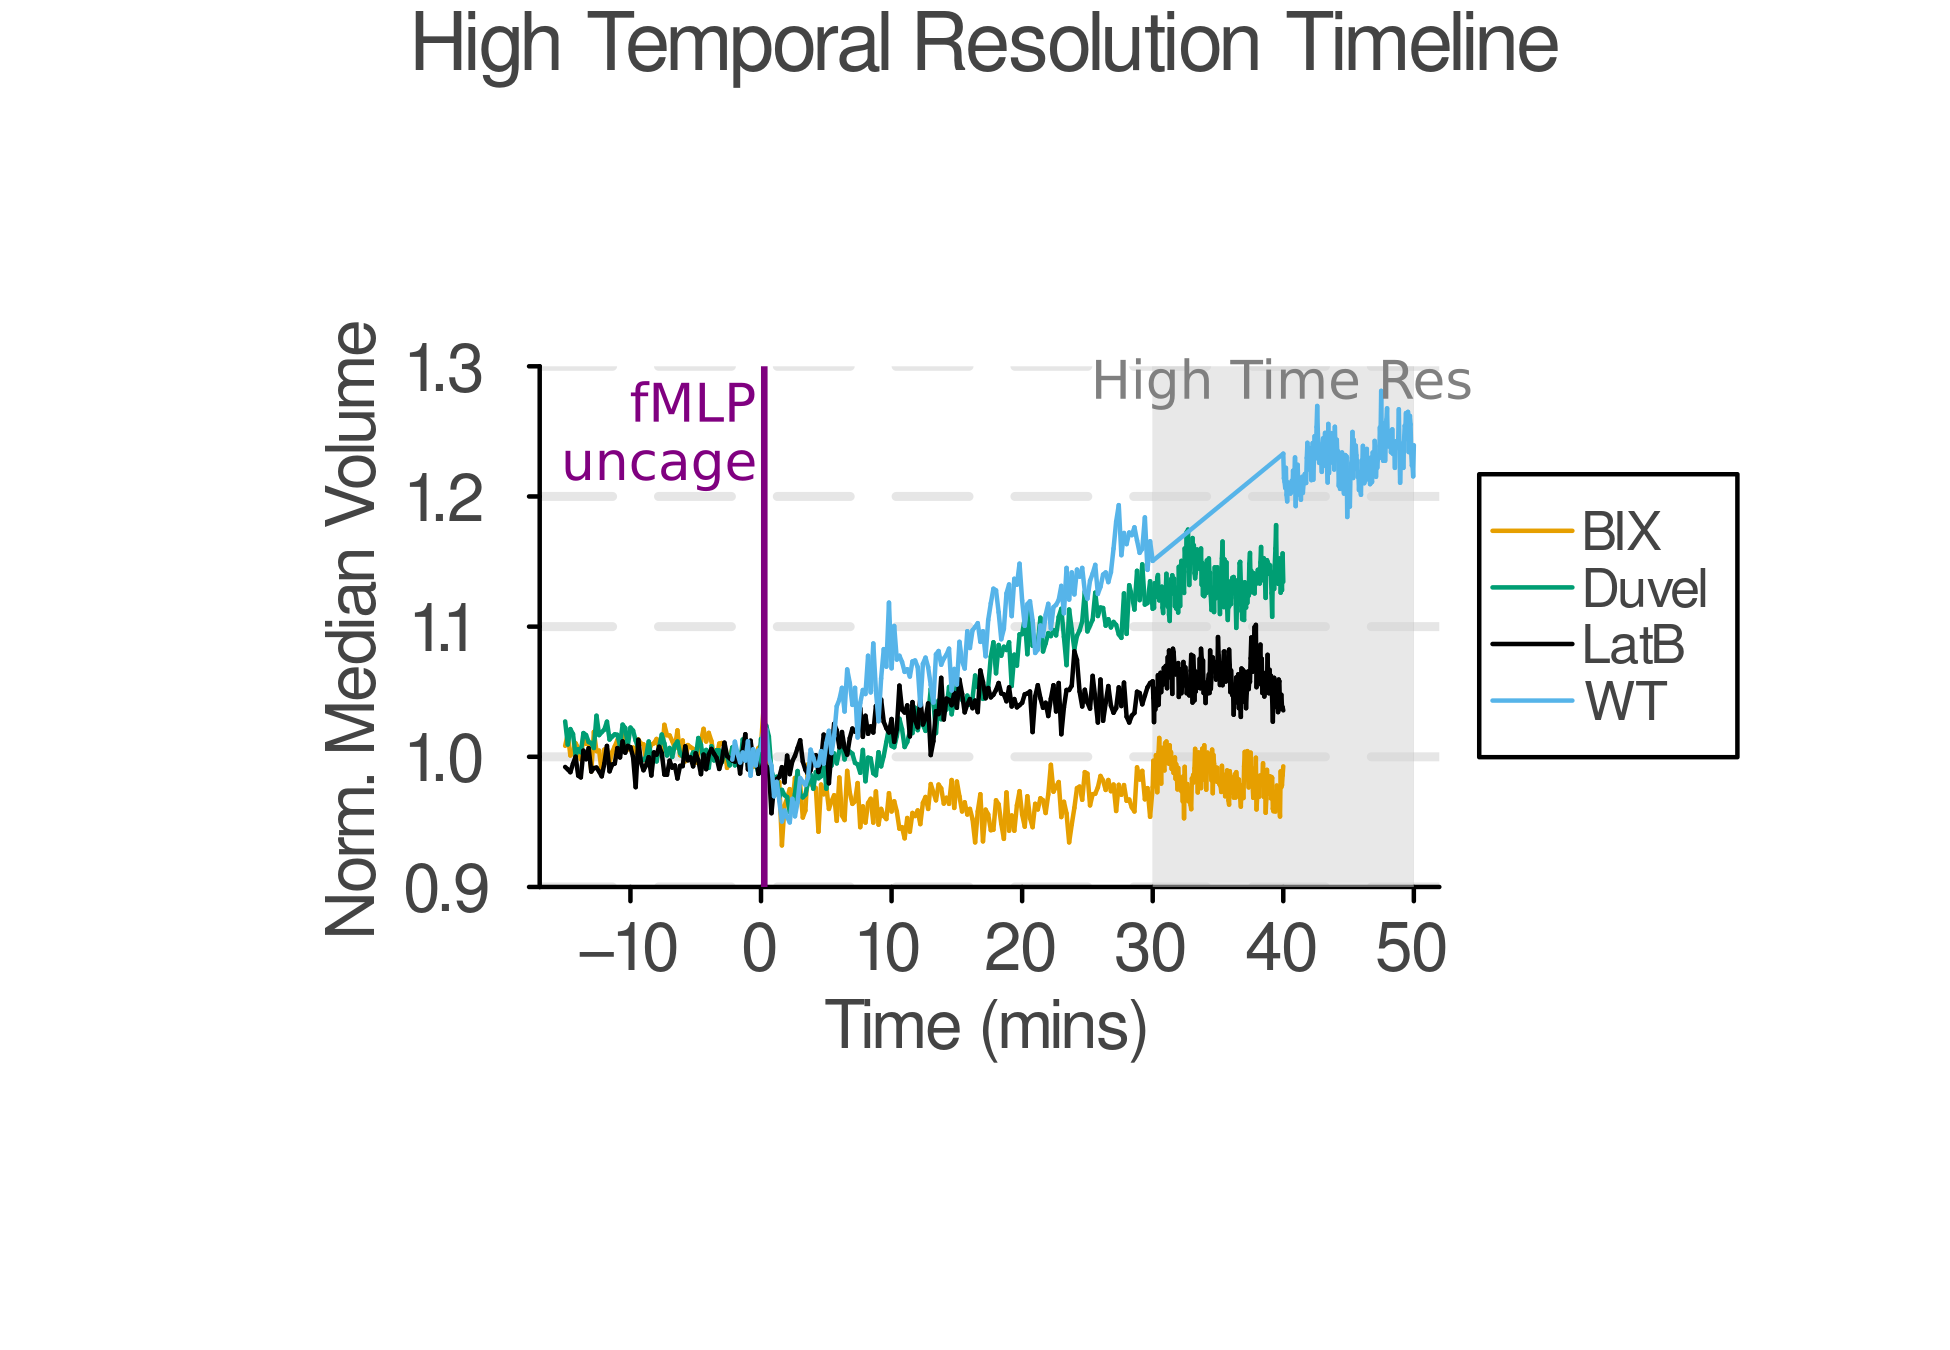

In [6]:
cmap = Dict("WT" => okabe_ito[1], "BIX" => okabe_ito[2], "Duvel" => okabe_ito[4], "BIXOSMO" => okabe_ito[8], "LatB" => okabe_ito[5]);
vspan([30u"minute", 50u"minute"], c = colorant"lightgray", alpha = 0.5, label = "")
annotate!(40, 1.29, text("High Time Res", :gray, :center, 8))
@df sort(med_vols, :reltime) plot!(:reltime, :v ./ getindex.(Ref(baseline_vs), :condition), #ribbon = (:v .- :l, :u .- :v),
    group = :condition, c = getindex.(Ref(cmap), :condition), ylim = (0.9, 1.3),
    leg = :outerright, framestyle = :axes, grid = :y, title = "High Temporal Resolution Timeline",
    xlabel = P"Time (mins)", ylabel = "Norm. Median Volume", margin = 50px)
vspan!([0, 0.5], c=colorant"purple", label = "")
annotate!(-0.5, 1.25, text("fMLP\nuncage", :purple, :right, 8), size = (650, 450), label = "")

## Compute outlines for all cells using their CartesianIndices

We need to do this transformation because we have the CartesianIndices
corresponding to all the XY pixels belonging to a cell, but for plotting we
need the outermost pixels oriented in a clockwise fashion.

In [7]:
round_to(n, x) = round(Int, x / n) * n
getoutline(locality::E; degree_bin = 10) where {E <: AbstractVector{<: EmbedVector}} = getoutline(first(locality); degree_bin = degree_bin)
"""
    getoutline(locality; degree_bin)

Given a list of CartesianIndices forming a locality, returns the (x,y)
coordinates of the outer points in clockwise order. The points are binned
together every `degree_bin` degrees.
"""
function getoutline(locality::E; degree_bin = 10) where {E <: EmbedVector}
    locale = map(x->x.I, locality.values)
    xs = first.(locale)
    ys = last.(locale)

    cx, cy = mean(xs), mean(ys)

    degs = atand.(ys .- cy, xs .- cx);
    mapping = DefaultDict{Int, Vector{Int}}(() -> Int[])

    for (i, deg) in enumerate(degs)
        push!(mapping[round_to(degree_bin, deg)], i)
    end

    maxdistidxs = Dict{Int, Int}()

    for (deg, vals) in mapping
        maxdist = -1
        maxdistidx = -1
        for idx in vals
            dist = sqrt((xs[idx] - cx) ^ 2 + (ys[idx] - cy) ^ 2)
            if dist > maxdist
                maxdist = dist
                maxdistidx = idx
            end
        end
        maxdistidxs[deg] = maxdistidx
    end

    # list of indices that are the farthest away
    vs = getindex.(Ref(maxdistidxs), sort(collect(keys(maxdistidxs))))
    push!(vs, vs[1])
    (ys[vs], xs[vs])
end

Main.var"##644".getoutline

## Only load data for representative cells

In [8]:
representative_cells = Set([
    ("WT", 47),
    ("BIX", 49),
    ("Duvel", 30),
    ("LatB", 49)
])

types = Dict(
    :abs_volume_um3 => Measurement{Float64},
    :condition => String,
    :particle => Int,
    :frame => Int,
    :time_s => Float64,
    :x => Float64,
    :y => Float64,
    :footprint_cart => EmbedVector{CartesianIndex{2}, ';'},
    :locality_cart => EmbedVector{CartesianIndex{2}, ';'},
    :dataset => String
)
highrescsvpath = joinpath(rootfolder, "data", "fxm_highres_augmented_w_localities.csv")
highrescells = CSV.Rows(highrescsvpath; types = types, select = collect(keys(types))) |>
    TableOperations.filter(x->(Tables.getcolumn(x, :condition), Tables.getcolumn(x, :particle)) in representative_cells) |> DataFrame;

> **Note**
>
> Filtering the rows on read like above is only necessary to limit memory
> usage on Github Actions since normally we can just load the CSV into
> memory and filter as needed.

In [9]:
transform!(highrescells,
    :locality_cart => ByRow(getoutline),
    :footprint_cart => ByRow(getoutline));

Now, we need a function that slices out a cell from the larger image

In [10]:
"""
    getcell(img, c)

Given a DataFrameRow `c` and an image `img`, this function uses the locality
information in `c` to slice out the cell from the provided image.
"""
function getcell(img, c; combo = true)
    locality = c.locality_cart.values
    combo = combo ? vcat(locality, c.footprint_cart.values) : c.footprint_cart.values
    imgslice = view(img, :, :, c.frame + 1);

    mn, mx = extrema(combo)

    target = OffsetArray(ones(eltype(imgslice), (mx - mn + CartesianIndex(1,1)).I), OffsetArrays.Origin(mn))
    target[combo] .= imgslice[combo]#, LinearStretching(nothing => (0.1, 1.3)))
    (img = target, img_ex = extrema(target))
end

Main.var"##644".getcell

### Plot utility functions

In [11]:
function faint(c)
    tmp = HSL(c)
    RGB(HSL(tmp.h, tmp.s, 0.85))
end
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h]);

getdataset(y) = filter(x->occursin(basename(y), x) & occursin("highres", x) & occursin("fxmcorr", x), readdir(joinpath(rootfolder, "data", "fxm", "flat")))[1]

getdataset (generic function with 1 method)

## Plot control cell high resolution volume fluctuations

In [12]:
c = filter(x->x.condition == "WT", highrescells)
wtcell = c

imgname = first(filter(x->x.condition == "WT", datasets)).datapath * "_fxmcorr.tif"

open(joinpath(rootfolder, "data", imgname)) do f
    img = TiffImages.load(f, mmap = true);

    transform!(c,
        AsTable(:) => ByRow(x->getcell(img, x)) => AsTable)
end

crng = Float64.((median(first.(c.img_ex)), median(last.(c.img_ex))))

c.img .= adjust_histogram.(c.img, Ref(LinearStretching(crng => (0.1, 1.3))));

c.reltime = uconvert.(u"minute", c.time_s .* u"s") .+ 40u"minute";

For the animation, we have to iterate over each frame in `c` and plot the
results

> **Tip**
>
> Here we are only rendering the last frame instead of running through and
> generating the full animation due to the memory limitations of the Github
> workers building this site.

    To generate the movie on your machine, uncomment the line with `@animate`
    below

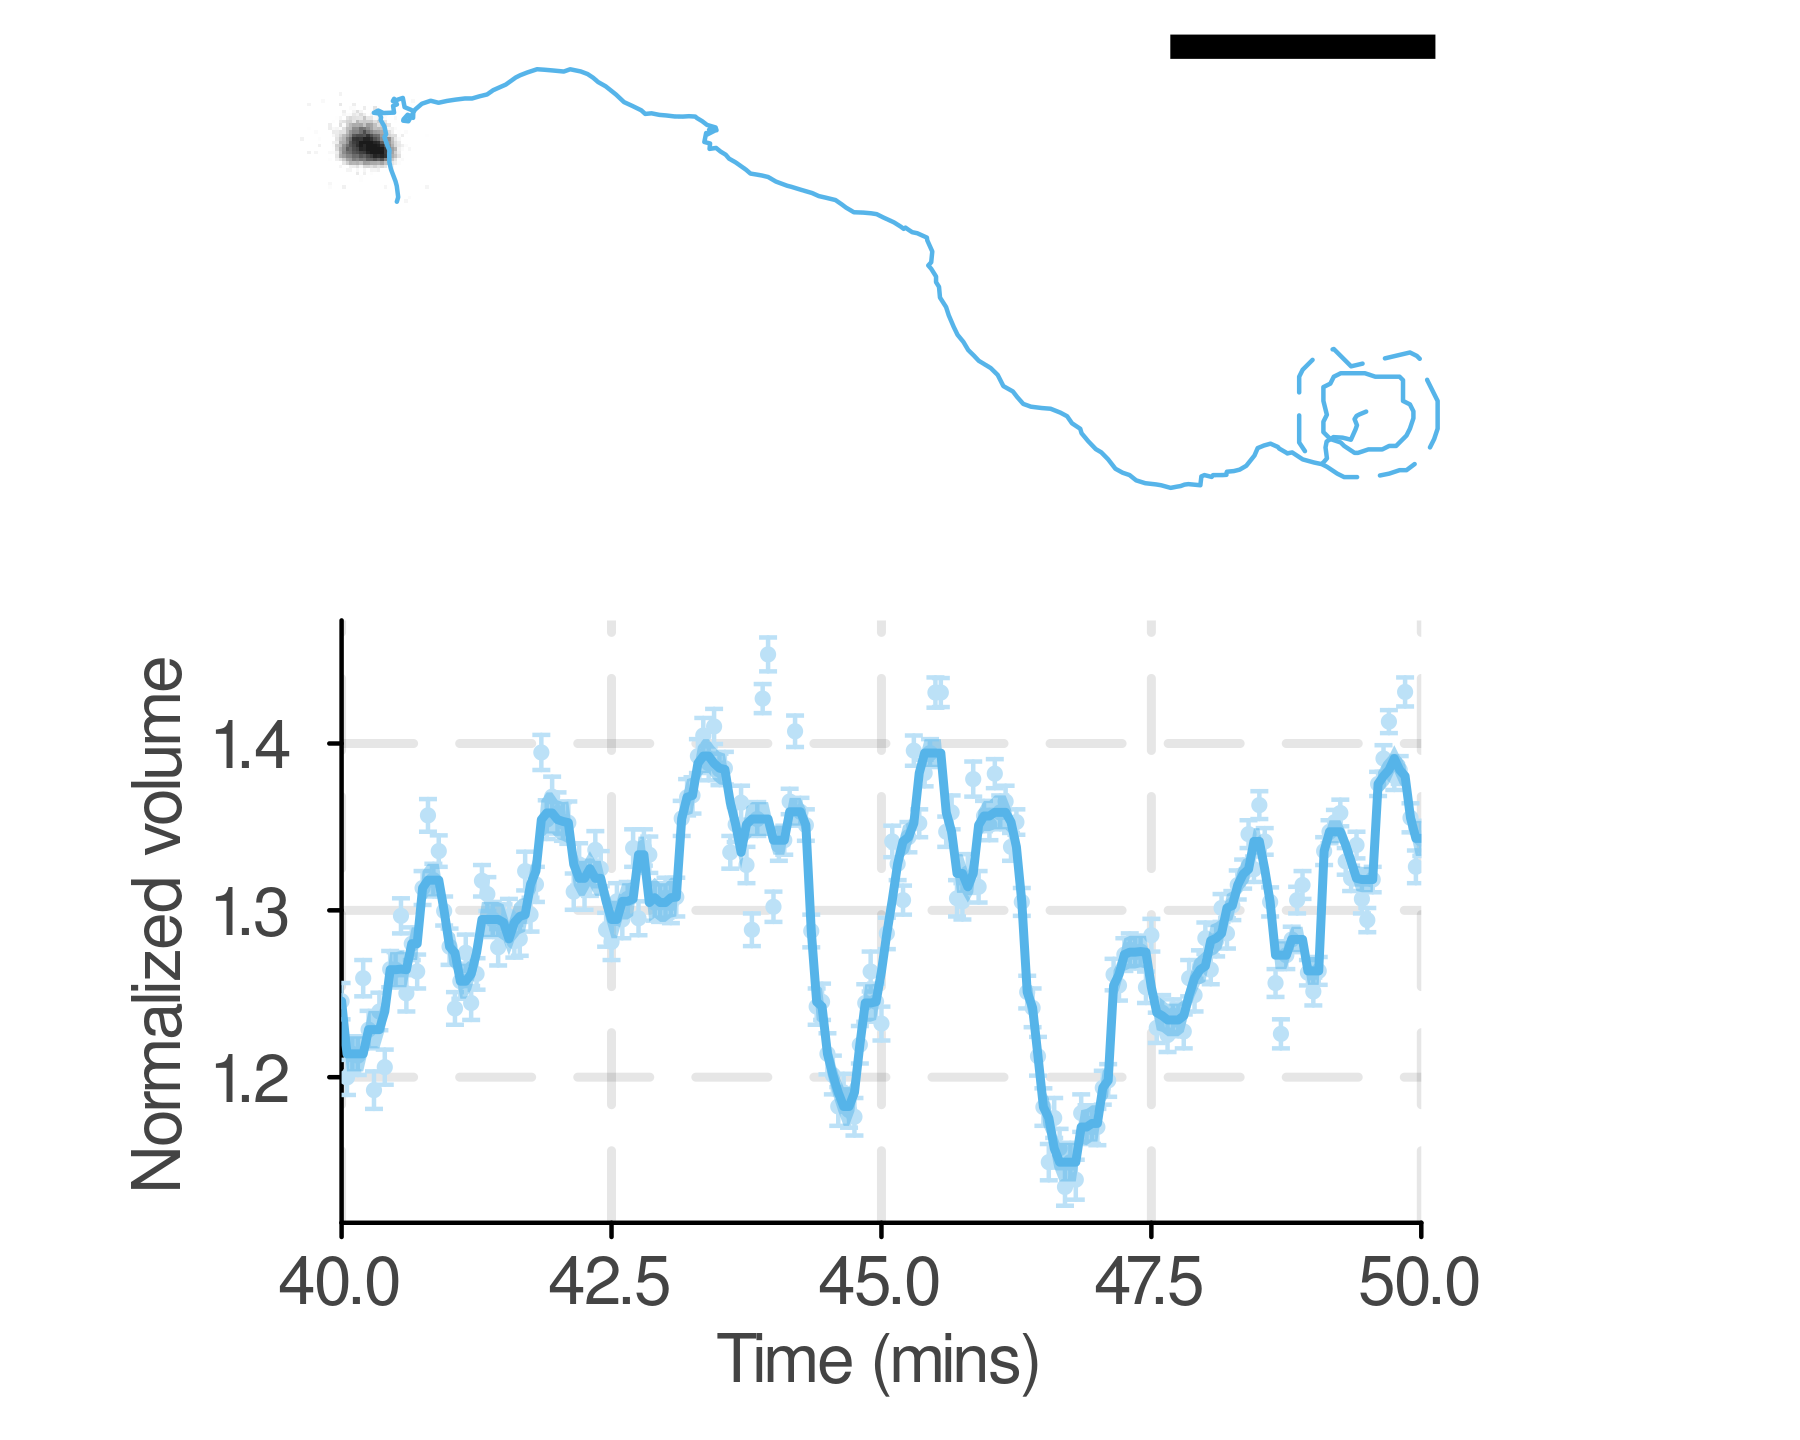

In [13]:
# anim = @animate for (i, r) in Iterators.drop(enumerate(eachrow(c)), 5)
anim = map(collect(Iterators.drop(enumerate(eachrow(c)), 5))[end:end]) do (i, r)
    prev_c = c[1:i, :]
    p2 = @df prev_c scatter(ustrip.(:reltime), :abs_volume_um3 ./ baseline_vs[first(c.condition)], xlim = ustrip.(extrema(c.reltime)),
                            markerstrokecolor = faint(okabe_ito[1]), m = 2,
                            c = faint(okabe_ito[1]), label = "", topmargin = 130px)

    v = mapwindow(median, c[1:i, :abs_volume_um3] ./ baseline_vs[first(c.condition)], -2:2)
    @df prev_c plot!(ustrip.(:reltime), Measurements.value.(v), ribbon = (Measurements.uncertainty.(v), Measurements.uncertainty.(v)),
            xlabel = "Time (mins)", #xticks = 0:5:10, ylim = (0.8, 1.45),
            yticks = 0.8:0.1:1.4,
            ylabel = "Normalized volume", size = (600,480), bottommargin = -10px,
            framestyle = :axes, linewidth = 2, c = okabe_ito[1], leg = :outerright,
            tick_direction = :out, label = "", #topmargin = -15mm, leftmargin = 5mm, bottommargin = -5mm)
    )
    yrng, xrng = extrema(c.x) .+ (-20, 20),extrema(c.y) .+ (-30, 30)
    sz = xrng[2] - xrng[1], yrng[2] - yrng[1]
    x = 400
    p1 = plot!(permutedims(r.img, [2,1]), xlim = xrng, ylim = yrng,
        inset = bbox(0.15, 0.0, x * px, x / (sz[1]/sz[2]) * px),
        subplot = 2,
        xflip = true,
        leg = false, framestyle = :none, #grid = nothing,
        xticks = false, yticks = false)
    @df prev_c plot!(:y, :x, subplot = 2,group = :particle, aspect_ratio = 1.0, yflip = true, c = 1)

    plot!(r.locality_cart_getoutline[[2, 1]]..., c = 1, linestyle = :dash, label = "", subplot = 2)
    plot!(r.footprint_cart_getoutline[[2,1]]..., c = 1, label = "", subplot = 2)

    plot!(rectangle(50/0.653,7,xrng[1] + 10, yrng[1] + 10), subplot = 2,
        linewidth = 0, c=colorant"black", label = "")
end

savefig(anim[1], joinpath("assets", "sv2_still.png"))
anim[1]

If run on your own machine run the following lines to generate the animated
movie

```julia
cp(joinpath(anim.dir, anim.frames[end]), joinpath("assets", "sv2_still.png"); force = true)
mp4(anim, "sv2_video.mp4")
```
which should look this:


<video autoplay loop muted playsinline>
    <source src="../../../assets/sv2_video.mp4" type="video/mp4">
</video>

In [14]:
# Plot high time resolution volume fluctuations for a NHE1 inhibited cell

c = filter(x->x.condition == "BIX", highrescells)
bixcell = c

imgname = first(filter(x->x.condition == "BIX", datasets)).datapath * "_fxmcorr.tif"
img = TiffImages.load(joinpath(rootfolder, "data", imgname), mmap = true);

transform!(c,
    AsTable(:) => ByRow(x->getcell(img, x)) => AsTable)

crng = Float64.((median(first.(c.img_ex)), median(last.(c.img_ex))))

c.img .= adjust_histogram.(c.img, Ref(LinearStretching(crng => (0.1, 1.3))));

c.reltime = uconvert.(u"minute", c.time_s .* u"s") .+ 30u"minute"

# anim = @animate for (i, r) in Iterators.drop(enumerate(eachrow(c)), 5)
anim = map(collect(Iterators.drop(enumerate(eachrow(c)), 5))[end:end]) do (i, r)
    p2 = @df c[1:i, :] scatter(ustrip.(:reltime), :abs_volume_um3 ./ baseline_vs[first(c.condition)], xlim = ustrip.(extrema(c.reltime)),
            markerstrokecolor = faint(okabe_ito[2]), m = 2, c = faint(okabe_ito[2]), label = "", topmargin = 130px)
    v = mapwindow(median, c[1:i, :abs_volume_um3] ./ baseline_vs[first(c.condition)], -2:2)
    @df c[1:i, :] plot!(ustrip.(:reltime), Measurements.value.(v), ribbon = (Measurements.uncertainty.(v), Measurements.uncertainty.(v)),
            xlabel = "Time (mins)", #xticks = 0:5:10, ylim = (0.8, 1.45),
            yticks = 0.8:0.1:1.4,
            ylabel = "Normalized volume", size = (600,480), bottommargin = -10px,
            framestyle = :axes, linewidth = 2, c = okabe_ito[2], leg = :outerright,
            tick_direction = :out, label = "", #topmargin = -15mm, leftmargin = 5mm, bottommargin = -5mm)
)
    yrng, xrng = extrema(c.x) .+ (-20-40, 20+40),extrema(c.y) .+ (-20-80, 20+80)
    sz = xrng[2] - xrng[1], yrng[2] - yrng[1]
    x = 400
    p1 = plot!(permutedims(r.img, [2,1]), xlim = xrng, ylim = yrng,
        inset = bbox(0.15, 0.0, x * px, x / (sz[1]/sz[2]) * px),
        subplot = 2,
        xflip = true,
        leg = false, framestyle = :none, grid = nothing, xticks = false, yticks = false)
    @df c[1:i, :] plot!(:y, :x, subplot = 2,group = :particle, aspect_ratio = 1.0, yflip = true, c = 2)

    plot!(r.locality_cart_getoutline[[2, 1]]..., c = 2, linestyle = :dash, label = "", subplot = 2)
    plot!(r.footprint_cart_getoutline[[2,1]]..., c = 2, label = "", subplot = 2)

    plot!(rectangle(50/0.653,7,xrng[1] + 10, yrng[1] + 10), subplot = 2,
          linewidth = 0, c=colorant"black", label = "")


    # l = @layout [a{0.65h}; b{0.35h}]
    # plot(p2, size = (600, 400))0
    p2
end;

As we can see, NHE1 inhibited cells can move, but slowly:

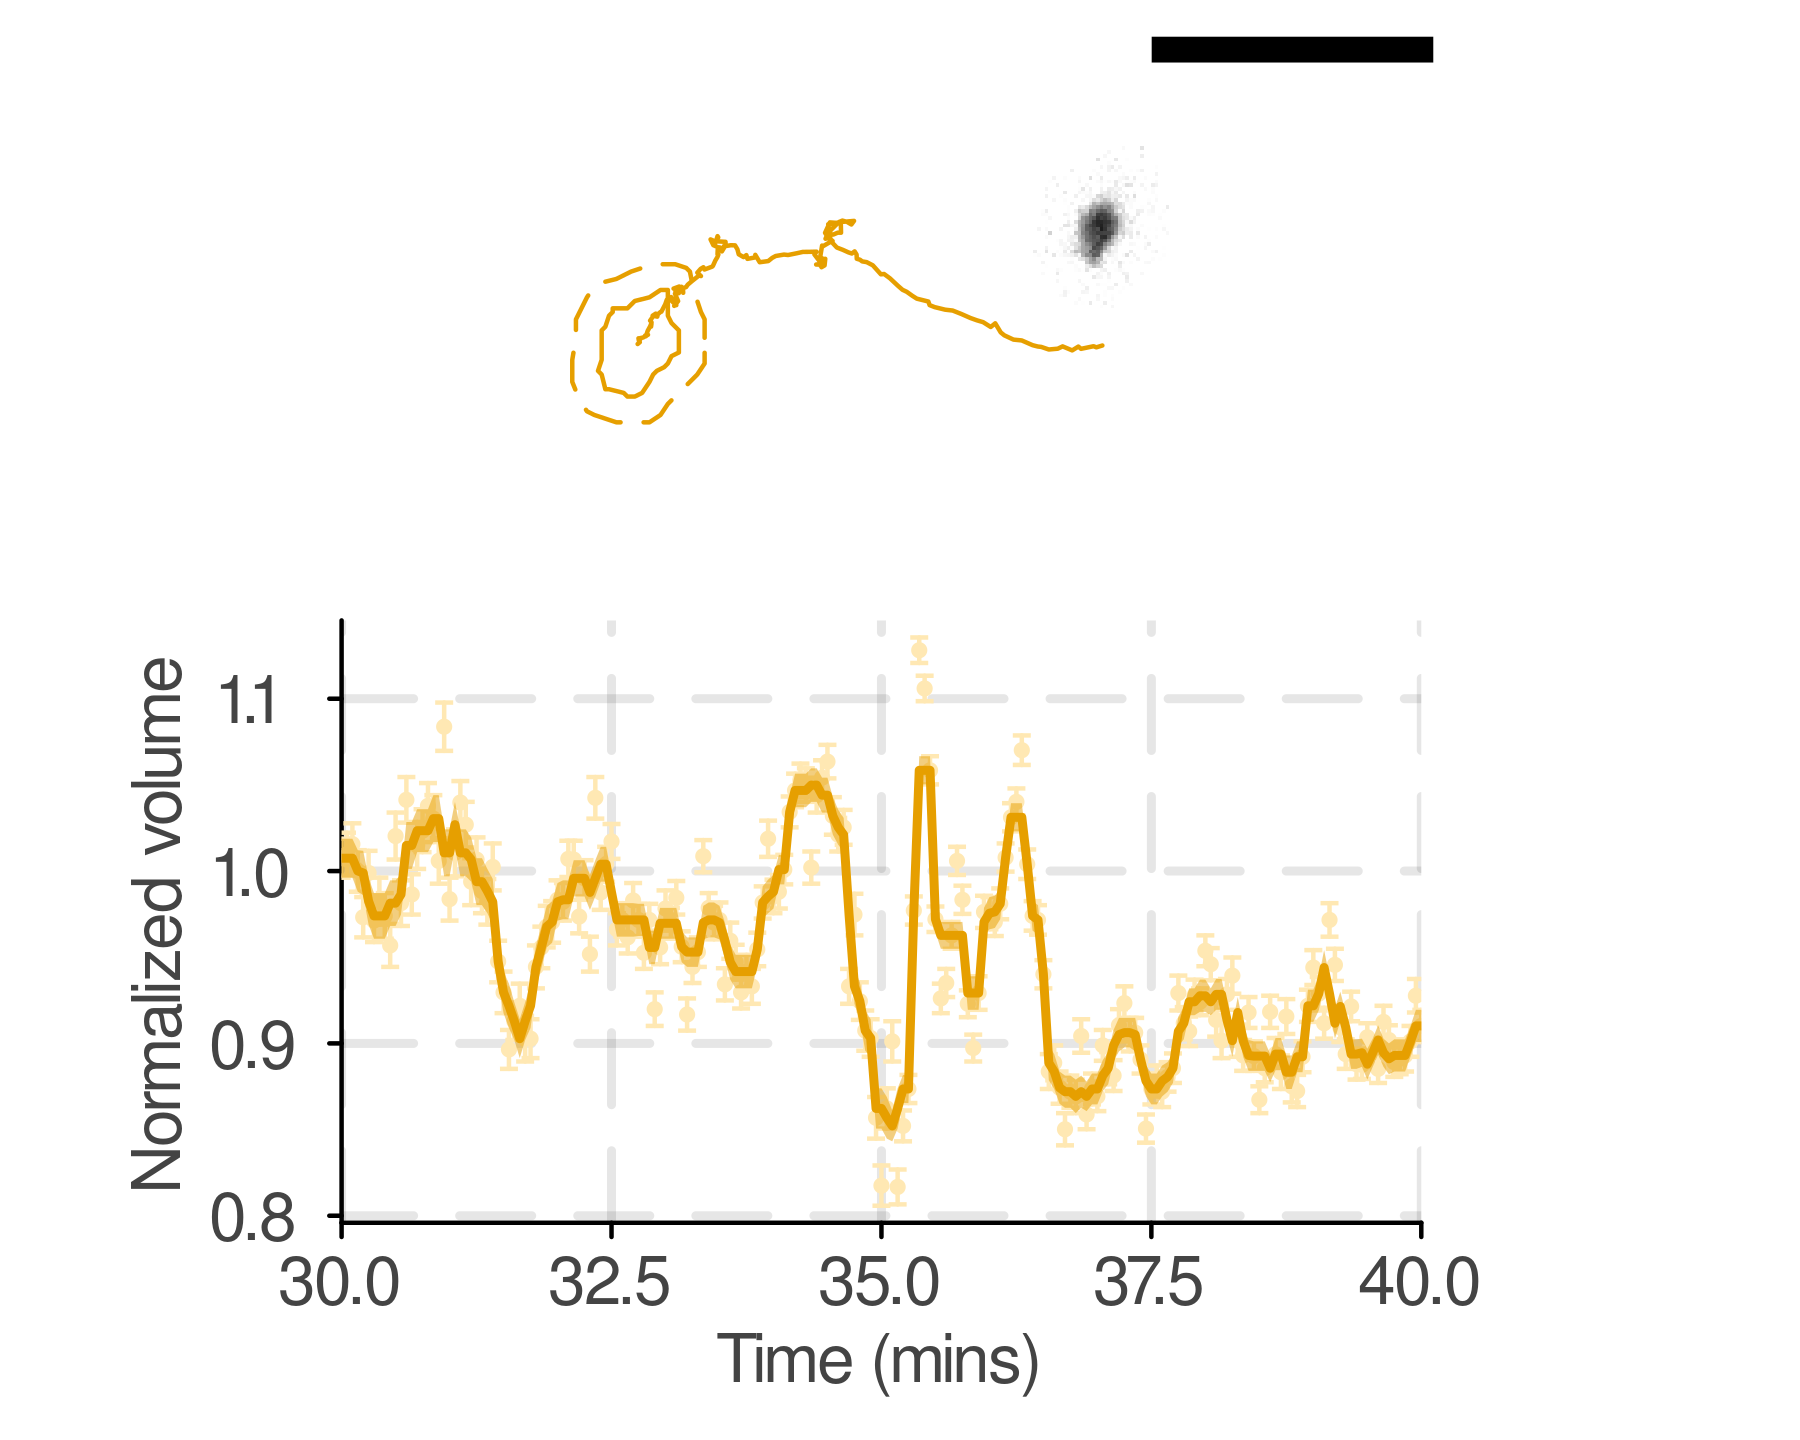

In [15]:
savefig(anim[1], joinpath("assets", "sv3_still.png"))
anim[1]

If run on your own machine run the following lines to generate the animated
movie of the iNHE1 cell:

```julia
cp(joinpath(anim.dir, anim.frames[end]), joinpath("assets", "sv3_still.png"); force = true)
mp4(anim, "sv3_video.mp4")
```
which should look this:


<video autoplay loop muted playsinline>
    <source src="../../../assets/sv3_video.mp4" type="video/mp4">
</video>

## Plot combined overlay

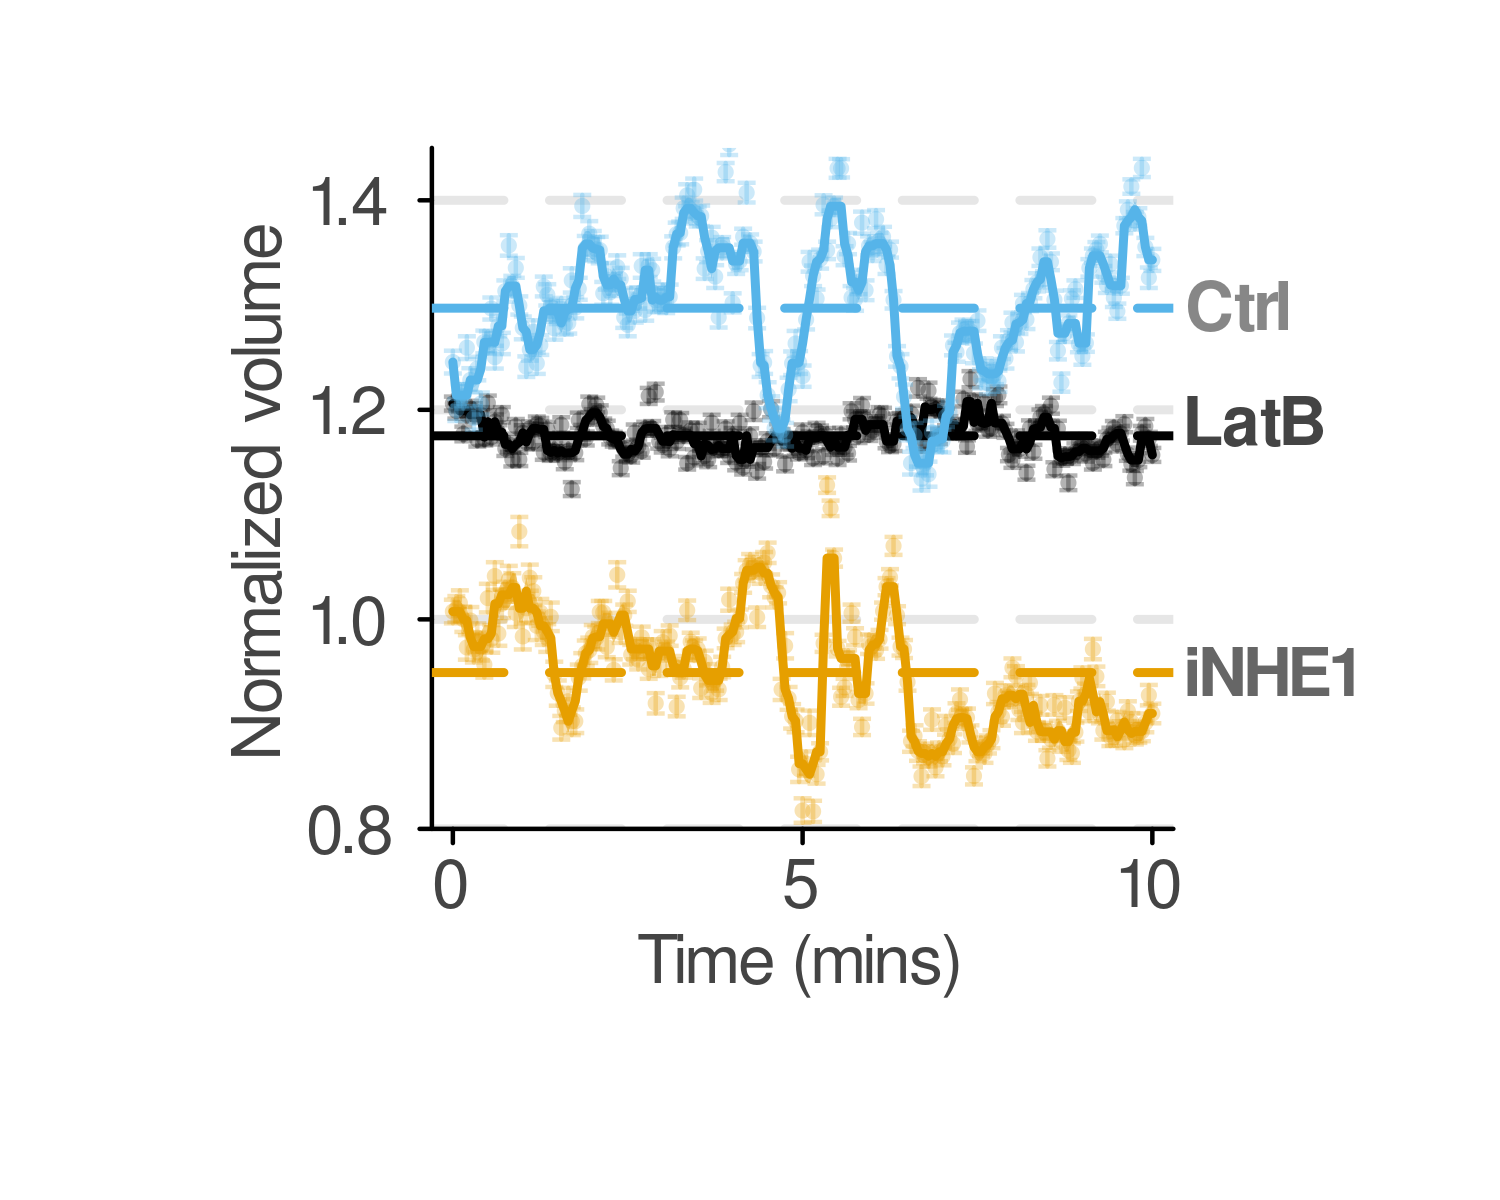

In [16]:
c = filter(x->x.condition == "LatB", highrescells)
latcell = c
c.reltime = uconvert.(u"minute", c.time_s .* u"s") .+ 30u"minute"

p = @df bixcell scatter(:reltime .- first(:reltime), :abs_volume_um3 ./ baseline_vs[first(:condition)], alpha = 0.3,
        markerstrokecolor = okabe_ito[2], m = 2, c = okabe_ito[2], label = "")

v = mapwindow(median, bixcell.abs_volume_um3, -2:2) ./ baseline_vs[first(bixcell.condition)]
@df bixcell plot!(:reltime .- first(:reltime), Measurements.value.(v), ribbon = (Measurements.uncertainty.(v), Measurements.uncertainty.(v)),
        ylabel = "Normalized volume",
        linewidth = 2, c = okabe_ito[2], label = "")
hline!([Measurements.value.(mean(v))], linewidth = 2, c = okabe_ito[2], linestyle = :dash,
    label = "")

@df latcell scatter!(:reltime .- first(:reltime), :abs_volume_um3 ./ baseline_vs[first(:condition)], alpha = 0.3,
        markerstrokecolor = okabe_ito[5], m = 2, c = okabe_ito[5], label = "")

v = mapwindow(median, latcell.abs_volume_um3, -2:2) ./ baseline_vs[first(latcell.condition)]
@df latcell plot!(:reltime .- first(:reltime), Measurements.value.(v), ribbon = (Measurements.uncertainty.(v), Measurements.uncertainty.(v)),
        framestyle = :axes, linewidth = 2, c = okabe_ito[5], leg = :outerright,
        tick_direction = :out, label = "")
hline!([Measurements.value.(mean(v))], linewidth = 2, c = okabe_ito[5], linestyle = :dash,
    label = "")

@df wtcell scatter!(:reltime .- first(:reltime), :abs_volume_um3 ./ baseline_vs[first(:condition)], alpha = 0.3,
        markerstrokecolor = okabe_ito[1], m = 2, c = okabe_ito[1], label = "")

v = mapwindow(median, wtcell.abs_volume_um3, -2:2) ./ baseline_vs[first(wtcell.condition)]
@df wtcell plot!(:reltime .- first(:reltime), Measurements.value.(v), ribbon = (Measurements.uncertainty.(v), Measurements.uncertainty.(v)),
        xlabel = P"Time (mins)", xticks = 0:5:10, ylim = (0.8, 1.45),
        yticks = 0.8:0.2:1.4,
        ylabel = "Normalized volume",
        framestyle = :axes, linewidth = 2, c = okabe_ito[1], leg = :outerright,
        tick_direction = :out, label = "")
hline!([Measurements.value.(mean(v))], linewidth = 2, c = okabe_ito[1], linestyle = :dash,
    label = "")

annotate!(10.5, 1.30, text("Ctrl", "Helvetica Bold", okabe_ito[1], :left, 10))
annotate!(10.5, 0.95, text("iNHE1", "Helvetica Bold", okabe_ito[2], :left, 10))
annotate!(10.5, 1.19, text("LatB", "Helvetica Bold", okabe_ito[5], :left, 10))

p1 = plot(p, grid = :y, margin = 25px, size = (500, 400))

savefig(p1, joinpath("assets", "single_cell.svg"))
p1

## Motile PI3Kγ cells show fluctuations

In [17]:
duvelcell = filter(x->x.condition == "Duvel", highrescells)
duvelcell.reltime = uconvert.(u"minute", duvelcell.time_s .* u"s") .+ 30u"minute"

p =  @df duvelcell scatter(:reltime .- first(:reltime), :abs_volume_um3 ./ baseline_vs[first(:condition)], alpha = 0.3,
        markerstrokecolor = okabe_ito[4], m = 2, c = okabe_ito[4], label = "")

v = mapwindow(median, duvelcell.abs_volume_um3, -2:2) ./ baseline_vs[first(duvelcell.condition)]
@df duvelcell plot!(:reltime .- first(:reltime), Measurements.value.(v), ribbon = (Measurements.uncertainty.(v), Measurements.uncertainty.(v)),
        framestyle = :axes, linewidth = 2, c = okabe_ito[4], leg = :outerright,
        tick_direction = :out, label = "")
hline!([Measurements.value.(mean(v))], linewidth = 2, c = okabe_ito[4], linestyle = :dash,
    label = "")

p1 = plot(p, grid = :y, size = (450, 350),
        xlabel = P"Time (mins)", xticks = 0:5:10, ylim = (0.8, 1.45),
        yticks = 0.8:0.2:1.4,
        ylabel = "Normalized volume")

c = filter(x->x.condition == "Duvel", highrescells)
duvelcell = c

imgname = first(filter(x->x.condition == "Duvel", datasets)).datapath * "_fxmcorr.tif"

open(joinpath(rootfolder, "data", imgname)) do f
    img = TiffImages.load(f, mmap = true);

    transform!(c,
        AsTable(:) => ByRow(x->getcell(img, x)) => AsTable)
end

crng = Float64.((median(first.(c.img_ex)), median(last.(c.img_ex))))

c.img .= adjust_histogram.(c.img, Ref(LinearStretching(crng => (0.1, 1.3))));

c.reltime = uconvert.(u"minute", c.time_s .* u"s") .+ 40u"minute";

# anim = @animate for (i, r) in Iterators.drop(enumerate(eachrow(c)), 5)
anim = map(collect(Iterators.drop(enumerate(eachrow(c)), 5))[end:end]) do (i, r)
    col = 4
    p2 = @df c[1:i, :] scatter(ustrip.(:reltime), :abs_volume_um3 ./ baseline_vs[first(c.condition)], xlim = ustrip.(extrema(c.reltime)),
            markerstrokecolor = faint(okabe_ito[col]), m = 2, c = faint(okabe_ito[col]), label = "", topmargin = 130px)
    v = mapwindow(median, c[1:i, :abs_volume_um3] ./ baseline_vs[first(c.condition)], -2:2)
    @df c[1:i, :] plot!(ustrip.(:reltime), Measurements.value.(v), ribbon = (Measurements.uncertainty.(v), Measurements.uncertainty.(v)),
            xlabel = "Time (mins)", #xticks = 0:5:10, ylim = (0.8, 1.45),
            yticks = 0.8:0.1:1.4,
            ylabel = "Normalized volume", size = (600,480), bottommargin = -10px,
            framestyle = :axes, linewidth = 2, c = okabe_ito[col], leg = :outerright,
            tick_direction = :out, label = "", #topmargin = -15mm, leftmargin = 5mm, bottommargin = -5mm)
)
    yrng, xrng = extrema(c.x) .+ (-20, 20),extrema(c.y) .+ (-20-130, 20+130)
    sz = xrng[2] - xrng[1], yrng[2] - yrng[1]
    x = 400
    p1 = plot!(permutedims(r.img, [2,1]), xlim = xrng, ylim = yrng,
        inset = bbox(0.15, 0.0, x * px, x / (sz[1]/sz[2]) * px),
        subplot = 2,
        xflip = true,
        leg = false, framestyle = :none, grid = nothing, xticks = false, yticks = false)
    @df c[1:i, :] plot!(:y, :x, subplot = 2,group = :particle, aspect_ratio = 1.0, yflip = true, c = col)

    plot!(r.locality_cart_getoutline[[2, 1]]..., c = col, linestyle = :dash, label = "", subplot = 2)
    plot!(r.footprint_cart_getoutline[[2,1]]..., c = col, label = "", subplot = 2)

    plot!(rectangle(50/0.653,7,xrng[1] + 10, yrng[1] + 10), subplot = 2,
          linewidth = 0, c=colorant"black", label = "")

    p2
end;

As we can see some PI3Kγ cells can move, but it's fairly slow movement:

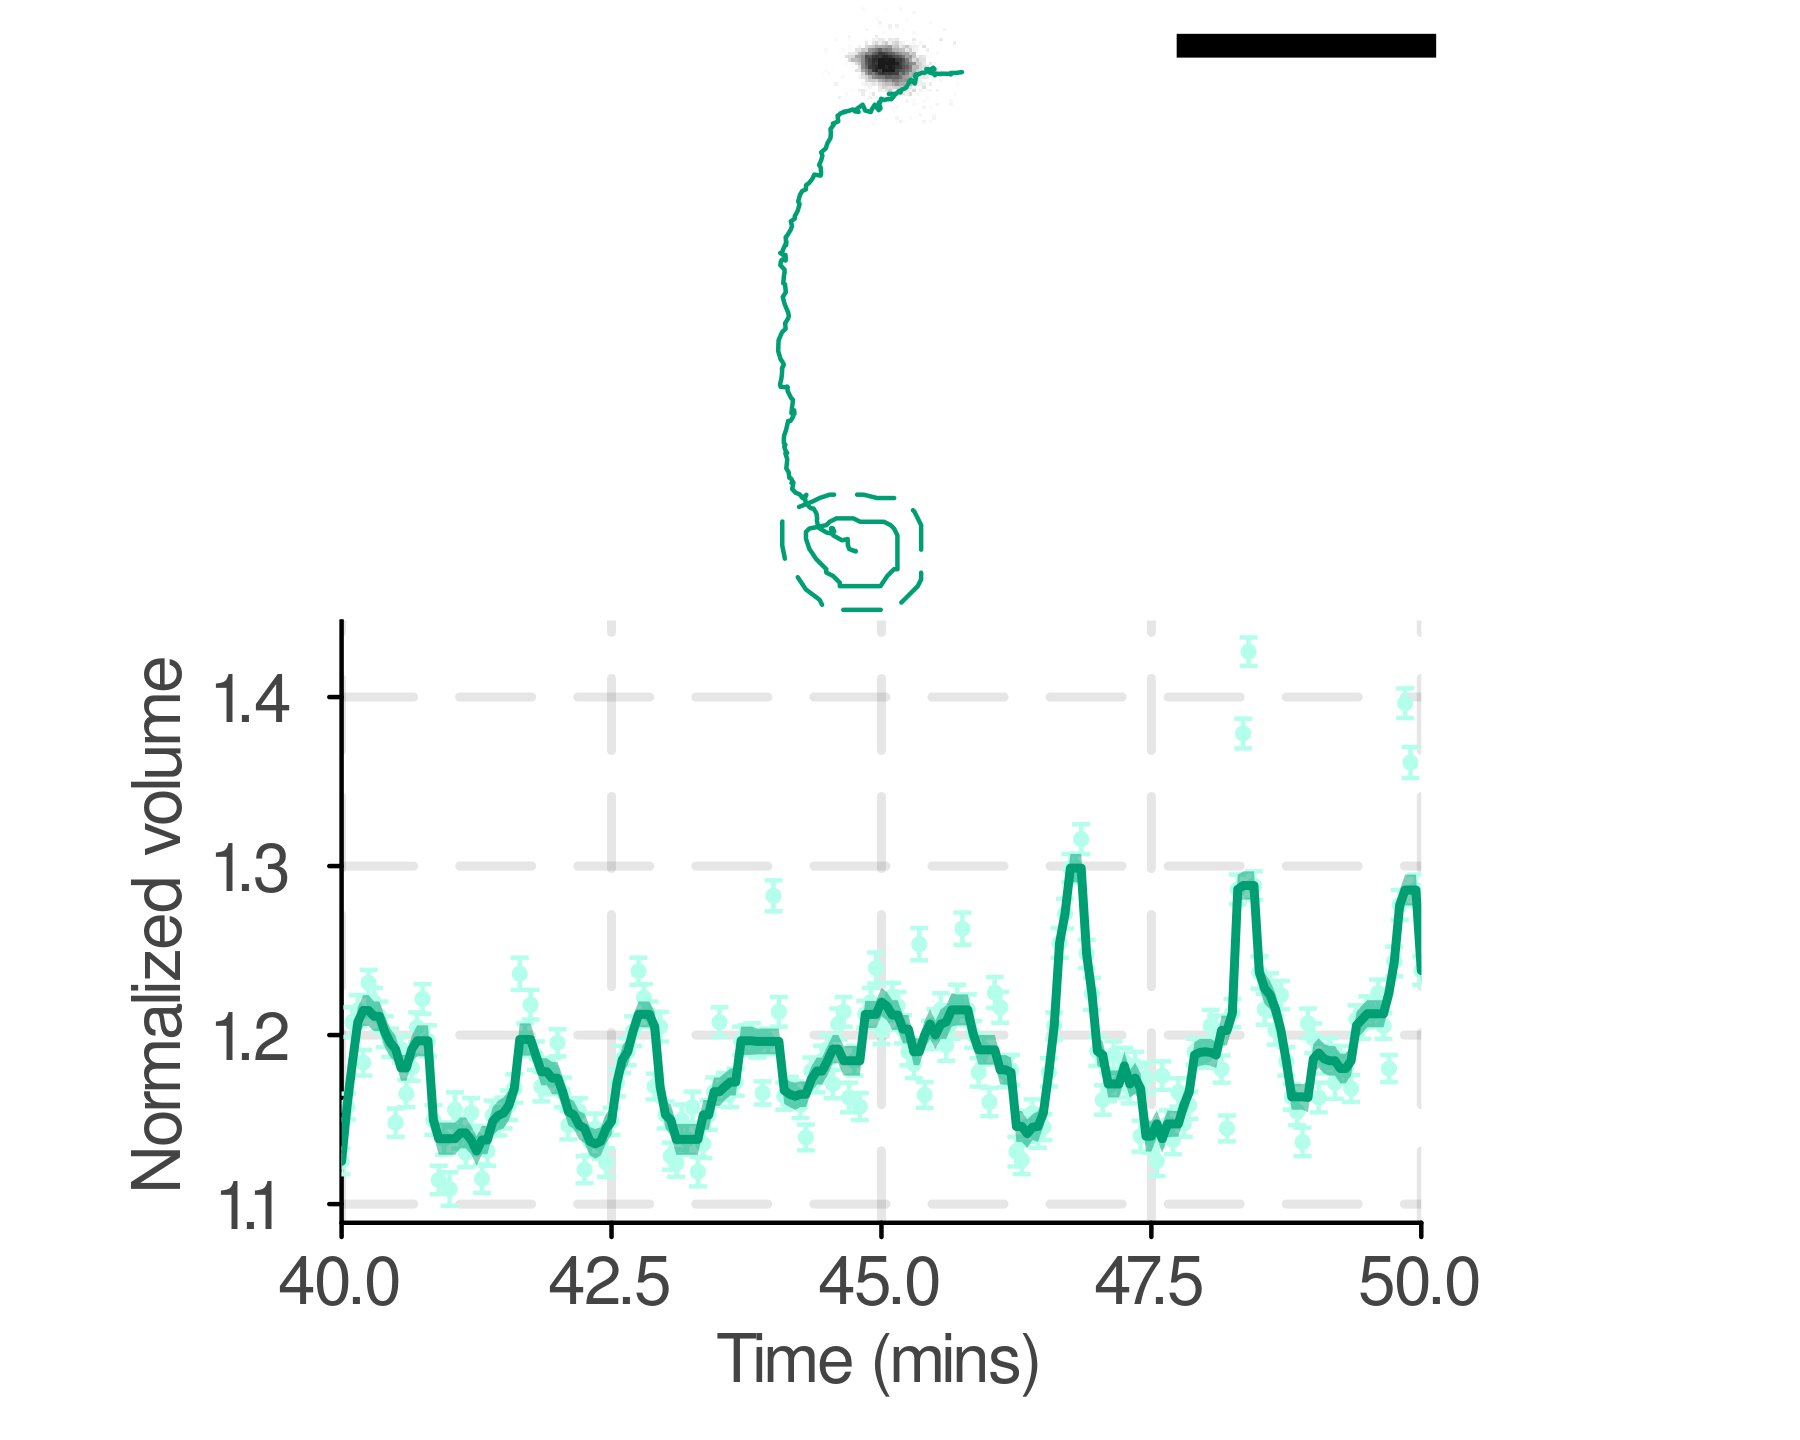

In [18]:
savefig(anim[1], joinpath("assets", "sv6_still.png"))
anim[1]

If run on your own machine run the following lines to generate the animated
movie of the PI3Kγ cell:

```julia
cp(joinpath(anim.dir, anim.frames[end]), joinpath("assets", "sv6_still.png"); force = true)
mp4(anim, "sv6_video.mp4")
```
which should look this:


<video autoplay loop muted playsinline>
    <source src="../../../assets/sv6_video.mp4" type="video/mp4">
</video>

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*